In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import ngrams

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pierr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pierr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pierr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pierr\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
df.head()

uniq_id            crawl_timestamp                                        product_url                                       product_name                              product_category_tree               pid  retail_price  discounted_price                                 image  is_FK_Advantage_product                                        description       product_rating       overall_rating                  brand                             product_specifications
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000  http://www.flipkart.com/elegance-polyester-mul...  Elegance Polyester Multicolor Abstract Eyelet ...  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False  Key Features of Elegance Polyester Multicolor ...  No rating available  No rating available               Elegance  {"product_specification"=>[{"key"=>"Brand", "v...
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000  http://www.flipkart.com/sathiyas-cotton-bath-t...                         Sathiyas Cotton Bath Towel  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False  Specifications of Sathiyas Cotton Bath Towel (...  No rating available  No rating available               Sathiyas  {"product_specification"=>[{"key"=>"Machine Wa...
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000  http://www.flipkart.com/eurospa-cotton-terry-f...                Eurospa Cotton Terry Face Towel Set  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg                    False  Key Features of Eurospa Cotton Terry Face Towe...  No rating available  No rating available                Eurospa  {"product_specification"=>[{"key"=>"Material",...
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000  http://www.flipkart.com/santosh-royal-fashion-...  SANTOSH ROYAL FASHION Cotton Printed King size...  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...  No rating available  No rating available  SANTOSH ROYAL FASHION  {"product_specification"=>[{"key"=>"Brand", "v...
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000  http://www.flipkart.com/jaipur-print-cotton-fl...  Jaipur Print Cotton Floral King sized Double B...  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg                    False  Key Features of Jaipur Print Cotton Floral Kin...  No rating available  No rating available           Jaipur Print  {"product_specification"=>[{"key"=>"Machine Wa...

In [3]:
df.shape

(1050, 15)

In [4]:
print('Nombre de produits = ', df.shape[0])
print('Nombre de variables = ',df.shape[1])

Nombre de produits =  1050
Nombre de variables =  15


In [5]:
df.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name', 'product_category_tree', 'pid', 'retail_price', 'discounted_price', 'image', 'is_FK_Advantage_product', 'description', 'product_rating', 'overall_rating', 'brand', 'product_specifications'], dtype='object')

In [6]:
df.isnull().sum().sort_values(ascending=False)

brand                      338
retail_price                 1
discounted_price             1
product_specifications       1
uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
dtype: int64

In [7]:
df.duplicated(subset=['uniq_id']).any()

False

In [8]:
print('Y a-t-il des doublons ? ',
      df.duplicated(subset=['uniq_id']).any())

Y a-t-il des doublons ?  False


## FEATURES TEXT

In [9]:
df['product_category_tree'][50]

'["Kitchen & Dining >> Coffee Mugs >> AKUP Coffee Mugs >> AKUP life-is-not-living Ceramic Mug (300 ml)"]'

In [10]:
# Determining the maximum tree depth of categories

df['product_category_tree'].apply(lambda x: x.count('>>')).max()


6

In [11]:
df['product_category_tree'].apply(lambda x: x.count('>>')).value_counts()

2    368
4    278
3    274
5     70
6     57
1      3
Name: product_category_tree, dtype: int64

In [12]:
#Last two characters:
df['product_category_tree'] = df['product_category_tree'].map(lambda x: str(x)[:-2])

#First two characters:
df['product_category_tree'] = df['product_category_tree'].map(lambda x: str(x)[2:])

In [13]:
df['product_category_tree'][50]

'Kitchen & Dining >> Coffee Mugs >> AKUP Coffee Mugs >> AKUP life-is-not-living Ceramic Mug (300 ml)'

In [14]:
df['product_category_tree'][50].split(' >> ')

['Kitchen & Dining',
 'Coffee Mugs',
 'AKUP Coffee Mugs',
 'AKUP life-is-not-living Ceramic Mug (300 ml)']

In [15]:
df['product_category_tree'] = df['product_category_tree'].str.split(' >> ')

In [16]:
df['product_category_tree'][0]

['Home Furnishing',
 'Curtains & Accessories',
 'Curtains',
 'Elegance Polyester Multicolor Abstract Eyelet Do...']

In [17]:
df['product_category_tree'][0][0]

'Home Furnishing'

In [18]:
df['cat_lvl_1'] = ''
df['cat_lvl_2'] = ''
df['cat_lvl_3'] = ''
df['cat_lvl_4'] = ''
df['cat_lvl_5'] = ''
df['cat_lvl_6'] = ''
df['cat_lvl_7'] = ''

In [19]:
df.head()

uniq_id            crawl_timestamp                                        product_url                                       product_name                              product_category_tree               pid  retail_price  discounted_price                                 image  is_FK_Advantage_product                                        description       product_rating       overall_rating                  brand                             product_specifications cat_lvl_1 cat_lvl_2 cat_lvl_3 cat_lvl_4 cat_lvl_5 cat_lvl_6 cat_lvl_7
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000  http://www.flipkart.com/elegance-polyester-mul...  Elegance Polyester Multicolor Abstract Eyelet ...  [Home Furnishing, Curtains & Accessories, Curt...  CRNEG7BKMFFYHQ8Z        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False  Key Features of Elegance Polyester Multicolor ...  No rating available  No rating available               Elegance  {"product_specification"=>[{"key"=>"Brand", "v...                                                                      
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000  http://www.flipkart.com/sathiyas-cotton-bath-t...                         Sathiyas Cotton Bath Towel  [Baby Care, Baby Bath & Skin, Baby Bath Towels...  BTWEGFZHGBXPHZUH         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False  Specifications of Sathiyas Cotton Bath Towel (...  No rating available  No rating available               Sathiyas  {"product_specification"=>[{"key"=>"Machine Wa...                                                                      
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000  http://www.flipkart.com/eurospa-cotton-terry-f...                Eurospa Cotton Terry Face Towel Set  [Baby Care, Baby Bath & Skin, Baby Bath Towels...  BTWEG6SHXTDB2A2Y           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg                    False  Key Features of Eurospa Cotton Terry Face Towe...  No rating available  No rating available                Eurospa  {"product_specification"=>[{"key"=>"Material",...                                                                      
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000  http://www.flipkart.com/santosh-royal-fashion-...  SANTOSH ROYAL FASHION Cotton Printed King size...  [Home Furnishing, Bed Linen, Bedsheets, SANTOS...  BDSEJT9UQWHDUBH4        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...  No rating available  No rating available  SANTOSH ROYAL FASHION  {"product_specification"=>[{"key"=>"Brand", "v...                                                                      
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000  http://www.flipkart.com/jaipur-print-cotton-fl...  Jaipur Print Cotton Floral King sized Double B...  [Home Furnishing, Bed Linen, Bedsheets, Jaipur...  BDSEJTHNGWVGWWQU        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg                    False  Key Features of Jaipur Print Cotton Floral Kin...  No rating available  No rating available           Jaipur Print  {"product_specification"=>[{"key"=>"Machine Wa...

In [20]:
for i in range(1050):
    if len(df['product_category_tree'][i]) >= 1: 
        df['cat_lvl_1'][i] = df['product_category_tree'][i][0]
        
for i in range(1050):
    if len(df['product_category_tree'][i]) >= 2: 
        df['cat_lvl_2'][i] = df['product_category_tree'][i][1]
        
for i in range(1050):
    if len(df['product_category_tree'][i]) >= 3: 
        df['cat_lvl_3'][i] = df['product_category_tree'][i][2]
        
for i in range(1050):
    if len(df['product_category_tree'][i]) >= 4: 
        df['cat_lvl_4'][i] = df['product_category_tree'][i][3]
        
for i in range(1050):
    if len(df['product_category_tree'][i]) >= 5: 
        df['cat_lvl_5'][i] = df['product_category_tree'][i][4]
        
for i in range(1050):
    if len(df['product_category_tree'][i]) >= 6: 
        df['cat_lvl_6'][i] = df['product_category_tree'][i][5]
        
for i in range(1050):
    if len(df['product_category_tree'][i]) >= 7: 
        df['cat_lvl_7'][i] = df['product_category_tree'][i][6]

In [21]:
df['cat_lvl_1'].value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: cat_lvl_1, dtype: int64

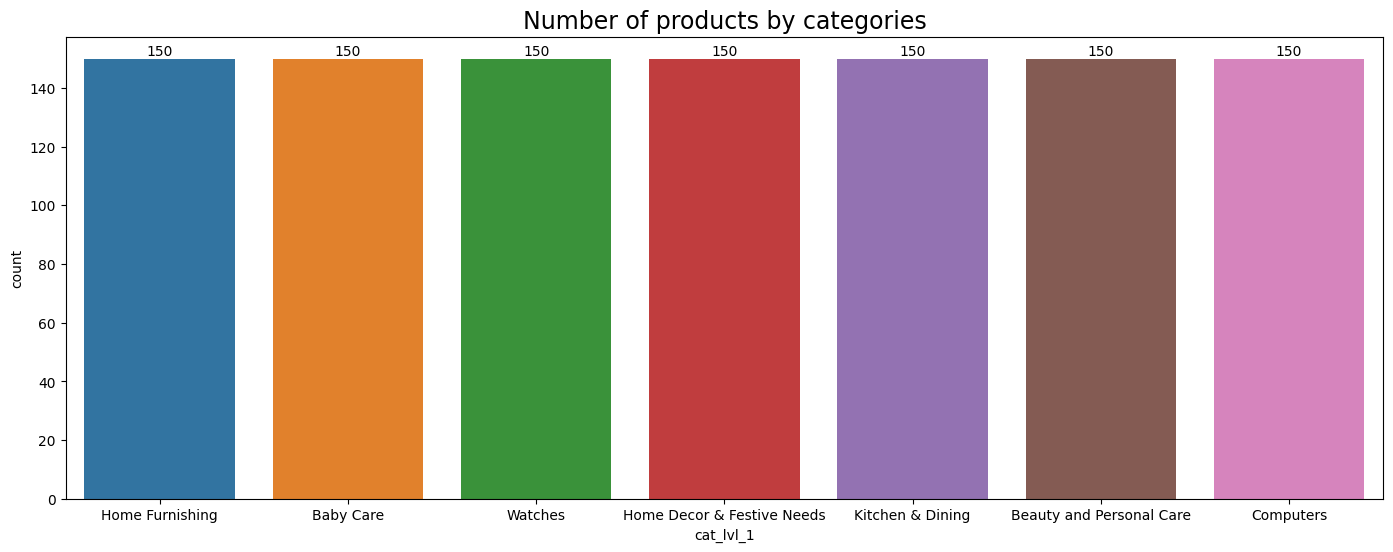

In [22]:
plt.figure(figsize=(17,6))
ax = sns.countplot(x='cat_lvl_1',data=df)
plt.title('Number of products by categories', size = 17)
for container in ax.containers:
    ax.bar_label(container)
plt.show()

In [23]:
df['cat_lvl_2'].value_counts()

Wrist Watches                      149
Laptop Accessories                  87
Infant Wear                         84
Coffee Mugs                         74
Showpieces                          71
Bed Linen                           65
Fragrances                          65
Network Components                  49
Cookware                            27
Table Decor & Handicrafts           27
Combos and Kits                     24
Wall Decor & Clocks                 22
Bath Linen                          21
Curtains & Accessories              19
Makeup                              18
Baby Bedding                        15
Body and Skin Care                  15
Baby & Kids Gifts                   15
Baby Bath & Skin                    14
Kitchen Tools                       14
Kitchen & Dining Linen              14
Decorative Lighting & Lamps         14
Containers & Bottles                13
Cushions, Pillows & Covers          13
Hair Care                            9
Feeding & Nursing        

In [24]:
df.head()

uniq_id            crawl_timestamp                                        product_url                                       product_name                              product_category_tree               pid  retail_price  discounted_price                                 image  is_FK_Advantage_product                                        description       product_rating       overall_rating                  brand                             product_specifications        cat_lvl_1               cat_lvl_2         cat_lvl_3                                          cat_lvl_4                                          cat_lvl_5 cat_lvl_6 cat_lvl_7
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000  http://www.flipkart.com/elegance-polyester-mul...  Elegance Polyester Multicolor Abstract Eyelet ...  [Home Furnishing, Curtains & Accessories, Curt...  CRNEG7BKMFFYHQ8Z        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False  Key Features of Elegance Polyester Multicolor ...  No rating available  No rating available               Elegance  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing  Curtains & Accessories          Curtains  Elegance Polyester Multicolor Abstract Eyelet ...                                                                       
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000  http://www.flipkart.com/sathiyas-cotton-bath-t...                         Sathiyas Cotton Bath Towel  [Baby Care, Baby Bath & Skin, Baby Bath Towels...  BTWEGFZHGBXPHZUH         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False  Specifications of Sathiyas Cotton Bath Towel (...  No rating available  No rating available               Sathiyas  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care        Baby Bath & Skin  Baby Bath Towels                          Sathiyas Baby Bath Towels  Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...                    
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000  http://www.flipkart.com/eurospa-cotton-terry-f...                Eurospa Cotton Terry Face Towel Set  [Baby Care, Baby Bath & Skin, Baby Bath Towels...  BTWEG6SHXTDB2A2Y           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg                    False  Key Features of Eurospa Cotton Terry Face Towe...  No rating available  No rating available                Eurospa  {"product_specification"=>[{"key"=>"Material",...        Baby Care        Baby Bath & Skin  Baby Bath Towels                           Eurospa Baby Bath Towels  Eurospa Cotton Terry Face Towel Set (20 PIECE ...                    
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000  http://www.flipkart.com/santosh-royal-fashion-...  SANTOSH ROYAL FASHION Cotton Printed King size...  [Home Furnishing, Bed Linen, Bedsheets, SANTOS...  BDSEJT9UQWHDUBH4        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...  No rating available  No rating available  SANTOSH ROYAL FASHION  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing               Bed Linen         Bedsheets                    SANTOSH ROYAL FASHION Bedsheets  SANTOSH ROYAL FASHION Cotton Printed King size...                    
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000  http://www.flipkart.com/jaipur-print-cotton-fl...  Jaipur Print Cotton Floral King sized Double B...  [Home Furnishing, Bed Linen, Bedsheets, Jaipur...  BDSEJTHNGWVGWWQU        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg                    False  Key Features of Jaipur Print Cotton Floral Kin...  No rating available  No rating available           Jaipur Print  {"product_specification"=>[{"key"=>"Machine Wa...  Home Furnishing               Bed Linen         Bedsheets                             Jaipur Print Bedsheets  Jaipur Print Cotton Floral King size

In [25]:
#normalization
sentence = 'I ate a LOT ! I LOVE fruits and vegetables'
sentence.lower()

'i ate a lot ! i love fruits and vegetables'

In [26]:
#tokenization
print(word_tokenize(sentence))

['I', 'ate', 'a', 'LOT', '!', 'I', 'LOVE', 'fruits', 'and', 'vegetables']


In [27]:
#stopwords and punctuation
stopw = stopwords.words('english')

exclude = set(string.punctuation)
tokens = word_tokenize(sentence)
print('input tokens : {}'.format(tokens))

stopw.extend(exclude)
tokens_without_stopw = [word for word in tokens if word not in stopw]
print('output tokens : {}'.format(tokens_without_stopw))

input tokens : ['I', 'ate', 'a', 'LOT', '!', 'I', 'LOVE', 'fruits', 'and', 'vegetables']
output tokens : ['I', 'ate', 'LOT', 'I', 'LOVE', 'fruits', 'vegetables']


In [28]:
#lemmatization
lemma = WordNetLemmatizer()
[lemma.lemmatize(lemma.lemmatize(lemma.lemmatize(word,pos='a'),pos='v'),pos='n') for word in tokens]

['I', 'eat', 'a', 'LOT', '!', 'I', 'LOVE', 'fruit', 'and', 'vegetable']

In [29]:
#ngrams
bigrams = ngrams(tokens, 2)
for words in bigrams:
    print(words)

('I', 'ate')
('ate', 'a')
('a', 'LOT')
('LOT', '!')
('!', 'I')
('I', 'LOVE')
('LOVE', 'fruits')
('fruits', 'and')
('and', 'vegetables')


In [30]:
#ngrams
trigrams = ngrams(tokens, 3)
for words in trigrams:
    print(words)

('I', 'ate', 'a')
('ate', 'a', 'LOT')
('a', 'LOT', '!')
('LOT', '!', 'I')
('!', 'I', 'LOVE')
('I', 'LOVE', 'fruits')
('LOVE', 'fruits', 'and')
('fruits', 'and', 'vegetables')


In [31]:
df["description"] = df["product_name"] + df["description"]

In [32]:
df["description"][0]

'Elegance Polyester Multicolor Abstract Eyelet Door CurtainKey Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant 

In [33]:
# Tokenizer

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemma.lemmatize(lemma.lemmatize(lemma.lemmatize(word,pos='a'),pos='v'),pos='n') for word in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

df['sentence_bow'] = df['description'].apply(lambda x : transform_bow_fct(x))
df['sentence_bow_lem'] = df['description'].apply(lambda x : transform_bow_lem_fct(x))
df['sentence_dl'] = df['description'].apply(lambda x : transform_dl_fct(x))


In [34]:
df.head()

uniq_id            crawl_timestamp                                        product_url                                       product_name                              product_category_tree               pid  retail_price  discounted_price                                 image  is_FK_Advantage_product                                        description       product_rating       overall_rating                  brand                             product_specifications        cat_lvl_1               cat_lvl_2         cat_lvl_3                                          cat_lvl_4                                          cat_lvl_5 cat_lvl_6 cat_lvl_7                                       sentence_bow                                   sentence_bow_lem                                        sentence_dl
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000  http://www.flipkart.com/elegance-polyester-mul...  Elegance Polyester Multicolor Abstract Eyelet ...  [Home Furnishing, Curtains & Accessories, Curt...  CRNEG7BKMFFYHQ8Z        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False  Elegance Polyester Multicolor Abstract Eyelet ...  No rating available  No rating available               Elegance  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing  Curtains & Accessories          Curtains  Elegance Polyester Multicolor Abstract Eyelet ...                                                                         elegance polyester multicolor abstract eyelet ...  elegance polyester multicolor abstract eyelet ...  elegance polyester multicolor abstract eyelet ...
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000  http://www.flipkart.com/sathiyas-cotton-bath-t...                         Sathiyas Cotton Bath Towel  [Baby Care, Baby Bath & Skin, Baby Bath Towels...  BTWEGFZHGBXPHZUH         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False  Sathiyas Cotton Bath TowelSpecifications of Sa...  No rating available  No rating available               Sathiyas  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care        Baby Bath & Skin  Baby Bath Towels                          Sathiyas Baby Bath Towels  Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...                      sathiyas cotton bath towelspecifications sathi...  sathiyas cotton bath towelspecifications sathi...  sathiyas cotton bath towelspecifications of sa...
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000  http://www.flipkart.com/eurospa-cotton-terry-f...                Eurospa Cotton Terry Face Towel Set  [Baby Care, Baby Bath & Skin, Baby Bath Towels...  BTWEG6SHXTDB2A2Y           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg                    False  Eurospa Cotton Terry Face Towel SetKey Feature...  No rating available  No rating available                Eurospa  {"product_specification"=>[{"key"=>"Material",...        Baby Care        Baby Bath & Skin  Baby Bath Towels                           Eurospa Baby Bath Towels  Eurospa Cotton Terry Face Towel Set (20 PIECE ...                      eurospa cotton terry face towel setkey feature...  eurospa cotton terry face towel setkey feature...  eurospa cotton terry face towel setkey feature...
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000  http://www.flipkart.com/santosh-royal-fashion-...  SANTOSH ROYAL FASHION Cotton Printed King size...  [Home Furnishing, Bed Linen, Bedsheets, SANTOS...  BDSEJT9UQWHDUBH4        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg                    False  SANTOSH ROYAL FASHION Cotton Printed King size...  No rating available  No rating available  SANTOSH ROYAL FASHION  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing               Bed Linen         Bedsheets                    SANTOSH ROYAL FASHION Bedsheets  SANTOSH ROYAL FASHION Cotton Printed King size...                      santosh royal fashion cotton p

In [35]:
#lenght without stopwords description by words
df['length_bow'] = df['sentence_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", df['length_bow'].max())

#lenght desctiption by words
df['length_dl'] = df['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", df['length_dl'].max())

max length bow :  383
max length dl :  636


In [36]:
df.head()

uniq_id            crawl_timestamp                                        product_url                                       product_name                              product_category_tree               pid  retail_price  discounted_price                                 image  is_FK_Advantage_product                                        description       product_rating       overall_rating                  brand                             product_specifications        cat_lvl_1               cat_lvl_2         cat_lvl_3                                          cat_lvl_4                                          cat_lvl_5 cat_lvl_6 cat_lvl_7                                       sentence_bow                                   sentence_bow_lem                                        sentence_dl  length_bow  length_dl
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000  http://www.flipkart.com/elegance-polyester-mul...  Elegance Polyester Multicolor Abstract Eyelet ...  [Home Furnishing, Curtains & Accessories, Curt...  CRNEG7BKMFFYHQ8Z        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False  Elegance Polyester Multicolor Abstract Eyelet ...  No rating available  No rating available               Elegance  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing  Curtains & Accessories          Curtains  Elegance Polyester Multicolor Abstract Eyelet ...                                                                         elegance polyester multicolor abstract eyelet ...  elegance polyester multicolor abstract eyelet ...  elegance polyester multicolor abstract eyelet ...         162        254
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000  http://www.flipkart.com/sathiyas-cotton-bath-t...                         Sathiyas Cotton Bath Towel  [Baby Care, Baby Bath & Skin, Baby Bath Towels...  BTWEGFZHGBXPHZUH         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False  Sathiyas Cotton Bath TowelSpecifications of Sa...  No rating available  No rating available               Sathiyas  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care        Baby Bath & Skin  Baby Bath Towels                          Sathiyas Baby Bath Towels  Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...                      sathiyas cotton bath towelspecifications sathi...  sathiyas cotton bath towelspecifications sathi...  sathiyas cotton bath towelspecifications of sa...          66         87
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000  http://www.flipkart.com/eurospa-cotton-terry-f...                Eurospa Cotton Terry Face Towel Set  [Baby Care, Baby Bath & Skin, Baby Bath Towels...  BTWEG6SHXTDB2A2Y           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg                    False  Eurospa Cotton Terry Face Towel SetKey Feature...  No rating available  No rating available                Eurospa  {"product_specification"=>[{"key"=>"Material",...        Baby Care        Baby Bath & Skin  Baby Bath Towels                           Eurospa Baby Bath Towels  Eurospa Cotton Terry Face Towel Set (20 PIECE ...                      eurospa cotton terry face towel setkey feature...  eurospa cotton terry face towel setkey feature...  eurospa cotton terry face towel setkey feature...         163        257
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000  http://www.flipkart.com/santosh-royal-fashion-...  SANTOSH ROYAL FASHION Cotton Printed King size...  [Home Furnishing, Bed Linen, Bedsheets, SANTOS...  BDSEJT9UQWHDUBH4        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg                    False  SANTOSH ROYAL FASHION Cotton Printed King size...  No rating available  No rating available  SANTOSH ROYAL FASHION  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing               Bed Linen         Bedsheets                    SANTOSH ROYAL FASHION Bedsheets  SANTOSH R

In [37]:
l_cat = list(set(df['cat_lvl_1']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(df.iloc[i]['cat_lvl_1'])) for i in range(len(df))]

catégories :  ['Home Furnishing', 'Computers', 'Watches', 'Baby Care', 'Home Decor & Festive Needs', 'Beauty and Personal Care', 'Kitchen & Dining']


In [38]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_, time2


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Representation of products by real categories')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Representation of products by cluster')
    
    plt.show()
    print("ARI : ", ARI)


## CountVectorizer and TfidfVectorizer 

In [40]:
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(df[feat])
ctf_fit = ctf.fit(df[feat])

cv_transform = cvect.transform(df[feat])  
ctf_transform = ctf.transform(df[feat])  

## Réduction de dimensions ( TruncatedSVD ) 

In [41]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", cv_transform.shape)
truncated_svd = decomposition.TruncatedSVD(n_components=761)
feat_pca = truncated_svd.fit_transform(cv_transform)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 5412)
Dimensions dataset après réduction PCA :  (1050, 761)


In [42]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels, time2 = ARI_fct(feat_pca)

CountVectorizer : 
-----------------
ARI :  0.4122 time :  10.0


In [43]:
data_ari = pd.DataFrame([['CountVectorizer', ARI, time2]],
                       columns = ['Model','ARI_score','Time'])
data_ari

Model  ARI_score  Time
0  CountVectorizer     0.4122  10.0

In [46]:
print("Dimensions dataset avant réduction PCA : ", ctf_transform.shape)
truncated_svd = decomposition.TruncatedSVD(n_components=907)
feat_pca = truncated_svd.fit_transform(ctf_transform)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 5412)
Dimensions dataset après réduction PCA :  (1050, 907)


In [47]:
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels, time2 = ARI_fct(feat_pca)

Tf-idf : 
--------
ARI :  0.5458 time :  8.0


In [48]:
data_ari2 = pd.DataFrame([['TF_IDF', ARI, time2]],
                       columns = ['Model','ARI_score','Time'])

data_ari = data_ari.append(data_ari2, ignore_index = True)

data_ari

Model  ARI_score  Time
0  CountVectorizer     0.4122  10.0
1           TF_IDF     0.5458   8.0

In [49]:
ctf_2 = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1, ngram_range=(1,2))

ctf_fit_2 = ctf_2.fit(df[feat])

ctf_transform_2 = ctf_2.transform(df[feat])

In [50]:
print("Dimensions dataset avant réduction PCA : ", ctf_transform_2.shape)
truncated_svd = decomposition.TruncatedSVD(n_components=958)
feat_pca = truncated_svd.fit_transform(ctf_transform_2)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 25691)
Dimensions dataset après réduction PCA :  (1050, 958)


In [51]:
print("Tf-idf_bigrams : ")
print("--------")
ARI_bigrams, X_tsne_bigrams, labels_bigrams, time2_bigrams = ARI_fct(feat_pca)

Tf-idf_bigrams : 
--------
ARI :  0.4658 time :  8.0


In [52]:
data_ari_bigrams = pd.DataFrame([['TF_IDF_bigrams', ARI_bigrams, time2_bigrams]],
                       columns = ['Model','ARI_score','Time'])

data_ari = data_ari.append(data_ari_bigrams, ignore_index = True)

data_ari

Model  ARI_score  Time
0  CountVectorizer     0.4122  10.0
1           TF_IDF     0.5458   8.0
2   TF_IDF_bigrams     0.4658   8.0

In [53]:
ctf_3 = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1, ngram_range=(1,3))

ctf_fit_3 = ctf_3.fit(df[feat])

ctf_transform_3 = ctf_3.transform(df[feat])

In [56]:
print("Dimensions dataset avant réduction PCA : ", ctf_transform_3.shape)
truncated_svd = decomposition.TruncatedSVD(n_components=967)
feat_pca = truncated_svd.fit_transform(ctf_transform_3)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 52669)
Dimensions dataset après réduction PCA :  (1050, 967)


In [57]:
print("Tf-idf_trigrams : ")
print("--------")
ARI_trigrams, X_tsne_trigrams, labels_trigrams, time2_trigrams = ARI_fct(ctf_transform_3)

Tf-idf_trigrams : 
--------
ARI :  0.5057 time :  12.0


In [58]:
data_ari_trigrams = pd.DataFrame([['TF_IDF_trigrams', ARI_trigrams, time2_trigrams]],
                       columns = ['Model','ARI_score','Time'])

data_ari = data_ari.append(data_ari_trigrams, ignore_index = True)

data_ari

Model  ARI_score  Time
0  CountVectorizer     0.4122  10.0
1           TF_IDF     0.5458   8.0
2   TF_IDF_bigrams     0.4658   8.0
3  TF_IDF_trigrams     0.5057  12.0

#### Graphiques 

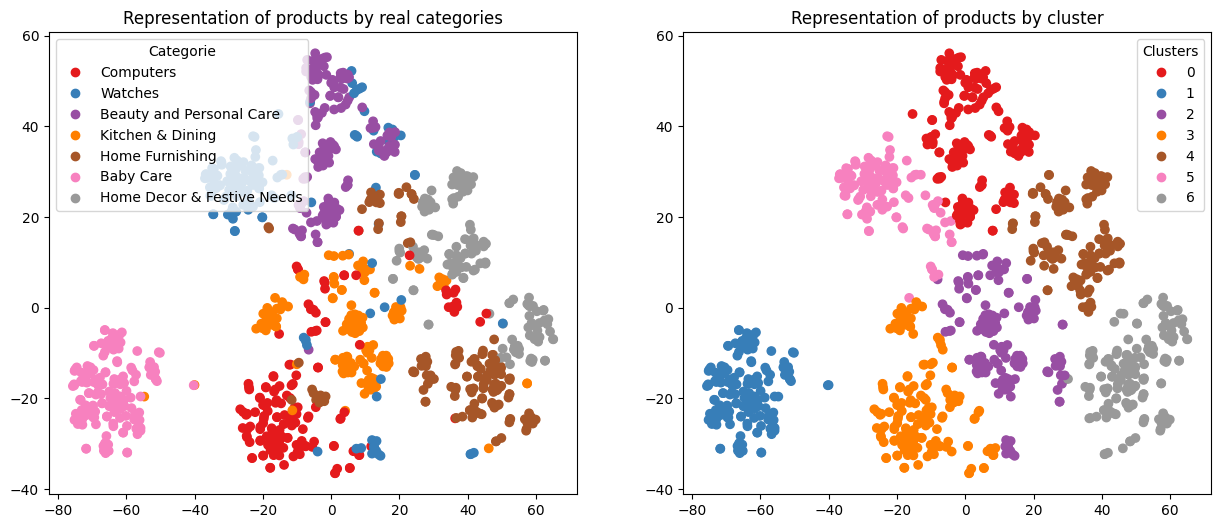

ARI :  0.5458


In [59]:
#tf idf ngram(1,1) 
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## Création du modèle Word2Vec

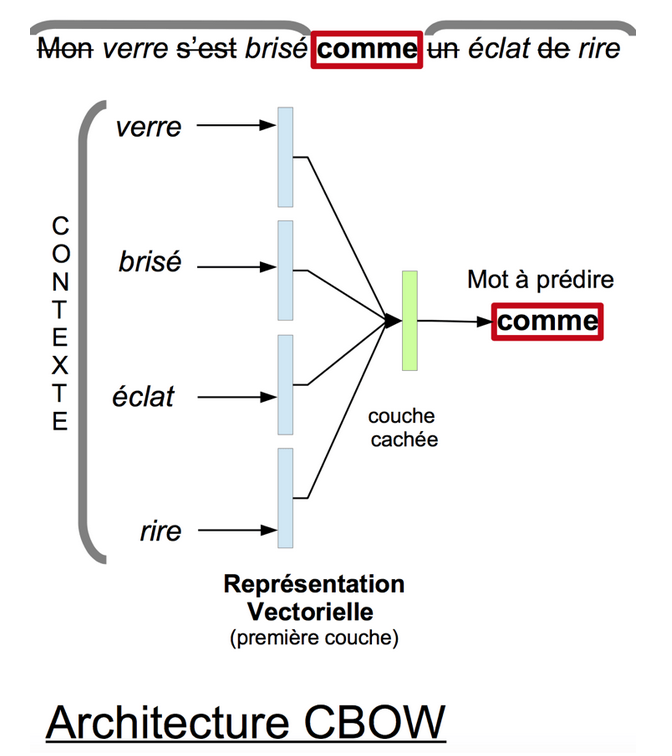

In [60]:
from IPython.display import Image
Image(filename='D:\pierr\Documents\images\word2vec.png',width=200,height=100)

In [61]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [62]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 385 # adapt to length of sentences
sentences = df['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [63]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4689
Word2Vec trained


In [64]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4690


### Création de la matrice d'embedding 

In [65]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4690, 300)


### Création du modèle d'embedding 

In [66]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 385)]             0         
                                                                 
 embedding (Embedding)       (None, 385, 300)          1407000   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,407,000
Trainable params: 1,407,000
Non-trainable params: 0
_________________________________________________________________


### Exécution du modèle 

In [67]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 1s 4ms/step


(1050, 300)

## Réduction de dimension 

In [69]:
print("Dimensions dataset avant réduction PCA : ", embeddings.shape)
pca = decomposition.PCA(n_components=0.99)
   
feat_pca = pca.fit_transform(embeddings)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 300)
Dimensions dataset après réduction PCA :  (1050, 55)


In [70]:
ARI, X_tsne, labels, time2 = ARI_fct(feat_pca)

ARI :  0.3812 time :  8.0


In [71]:
data_ari3 = pd.DataFrame([['Word2Vec', ARI, time2]],
                       columns = ['Model','ARI_score','Time'])

data_ari = data_ari.append(data_ari3, ignore_index = True)

data_ari

Model  ARI_score  Time
0  CountVectorizer     0.4122  10.0
1           TF_IDF     0.5458   8.0
2   TF_IDF_bigrams     0.4658   8.0
3  TF_IDF_trigrams     0.5057  12.0
4         Word2Vec     0.3812   8.0

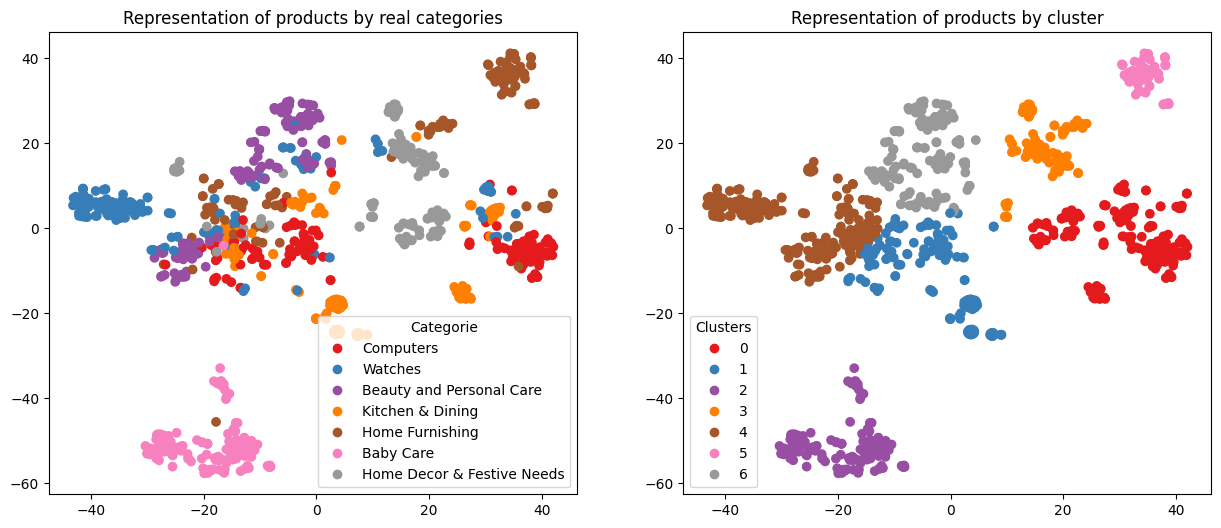

ARI :  0.3812


In [72]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT

In [73]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

### Fonctions communes

In [74]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [75]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['sentence_dl'].to_list()

loading configuration file config.json from cache at C:\Users\pierr/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at C:\Users\pierr/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb42

In [76]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at C:\Users\pierr/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\pierr/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\vocab.t

1/1 [==============================] - 1s 1s/step
temps traitement :  105.0


## Réduction de dimension 

In [77]:
print("Dimensions dataset avant réduction PCA : ", features_bert.shape)
pca = decomposition.PCA(n_components=0.99)
   
feat_pca = pca.fit_transform(features_bert)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 768)
Dimensions dataset après réduction PCA :  (1050, 369)


In [78]:
ARI, X_tsne, labels, time2 = ARI_fct(feat_pca)

ARI :  0.4751 time :  8.0


In [79]:
data_ari4 = pd.DataFrame([['BERT_HuggingFace_bert_base_uncased', ARI, time2]],
                       columns = ['Model','ARI_score','Time'])

data_ari = data_ari.append(data_ari4, ignore_index = True)

data_ari

Model  ARI_score  Time
0                     CountVectorizer     0.4122  10.0
1                              TF_IDF     0.5458   8.0
2                      TF_IDF_bigrams     0.4658   8.0
3                     TF_IDF_trigrams     0.5057  12.0
4                            Word2Vec     0.3812   8.0
5  BERT_HuggingFace_bert_base_uncased     0.4751   8.0

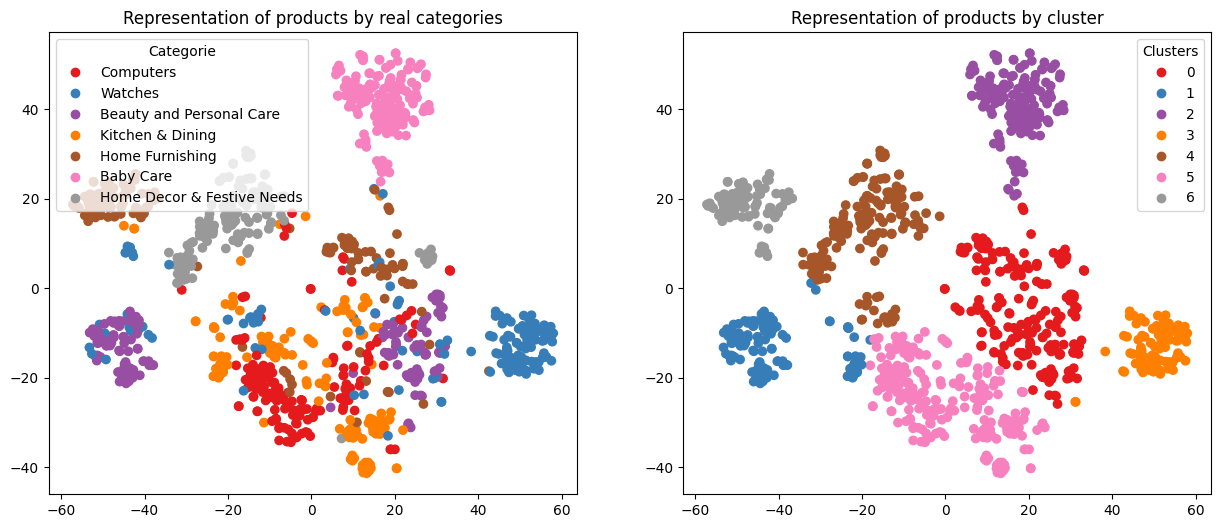

ARI :  0.4751


In [80]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### 'cardiffnlp/twitter-roberta-base-sentiment'

In [81]:
max_length = 64
batch_size = 10
model_type = 'cardiffnlp/twitter-roberta-base-sentiment'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['sentence_dl'].to_list()

loading configuration file config.json from cache at C:\Users\pierr/.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment\snapshots\daefdd1f6ae931839bce4d0f3db0a1a4265cd50f\config.json
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute

In [82]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at C:\Users\pierr/.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment\snapshots\daefdd1f6ae931839bce4d0f3db0a1a4265cd50f\config.json
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads

1/1 [==============================] - 1s 684ms/step
temps traitement :  105.0


## Réduction de dimension 

In [83]:
print("Dimensions dataset avant réduction PCA : ", features_bert.shape)
pca = decomposition.PCA(n_components=0.99)
   
feat_pca = pca.fit_transform(features_bert)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 768)
Dimensions dataset après réduction PCA :  (1050, 205)


In [84]:
ARI, X_tsne, labels, time2 = ARI_fct(feat_pca)

ARI :  0.1934 time :  8.0


In [85]:
data_ari5 = pd.DataFrame([['BERT_HuggingFace_cardiffnlp/twitter_roberta_base_sentiment', ARI, time2]],
                       columns = ['Model','ARI_score','Time'])

data_ari = data_ari.append(data_ari5, ignore_index = True)

data_ari

Model  ARI_score  Time
0                                    CountVectorizer     0.4122  10.0
1                                             TF_IDF     0.5458   8.0
2                                     TF_IDF_bigrams     0.4658   8.0
3                                    TF_IDF_trigrams     0.5057  12.0
4                                           Word2Vec     0.3812   8.0
5                 BERT_HuggingFace_bert_base_uncased     0.4751   8.0
6  BERT_HuggingFace_cardiffnlp/twitter_roberta_ba...     0.1934   8.0

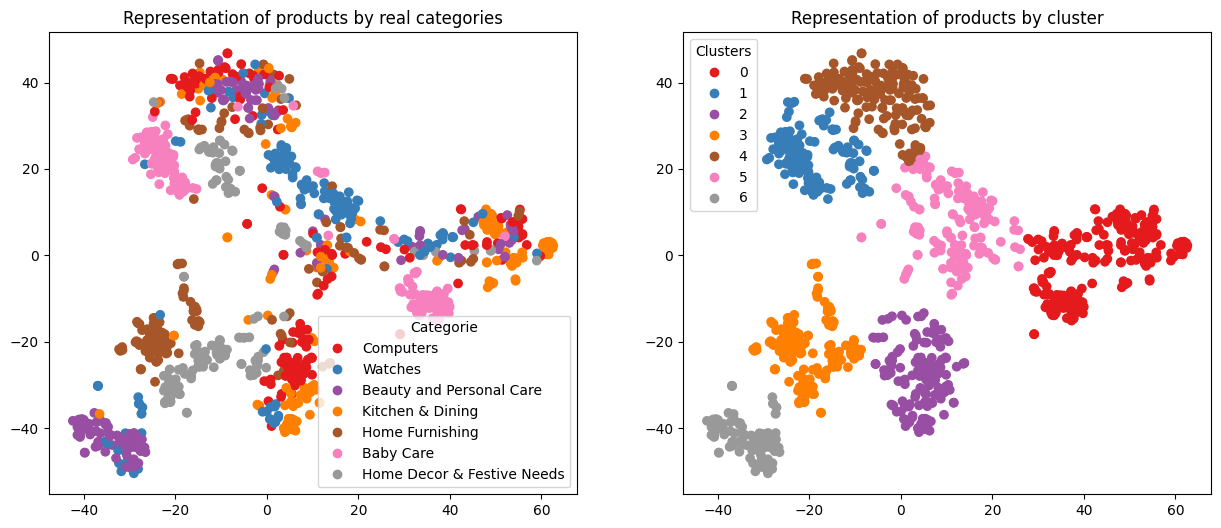

ARI :  0.1934


In [86]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT hub Tensorflow

In [104]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [105]:
sentences = df['sentence_dl'].to_list()

In [106]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

loading configuration file config.json from cache at C:\Users\pierr/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\pierr/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\vocab.t

temps traitement :  76.0


## Réduction de dimension 

In [107]:
print("Dimensions dataset avant réduction PCA : ", features_bert.shape)
pca = decomposition.PCA(n_components=0.99)
   
feat_pca = pca.fit_transform(features_bert)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 768)
Dimensions dataset après réduction PCA :  (1050, 369)


In [108]:
ARI, X_tsne, labels = ARI_fct(feat_pca)

ARI :  0.4779 time :  7.0


ValueError: too many values to unpack (expected 3)

In [109]:
data_ari6 = pd.DataFrame([['BERT_hub_Tensorflow', 0.4779, 7.0]],
                       columns = ['Model','ARI_score','Time'])

data_ari = data_ari.append(data_ari6, ignore_index = True)

data_ari

Model  ARI_score  Time
0                                    CountVectorizer     0.4122  10.0
1                                             TF_IDF     0.5458   8.0
2                                     TF_IDF_bigrams     0.4658   8.0
3                                    TF_IDF_trigrams     0.5057  12.0
4                                           Word2Vec     0.3812   8.0
5                 BERT_HuggingFace_bert_base_uncased     0.4751   8.0
6  BERT_HuggingFace_cardiffnlp/twitter_roberta_ba...     0.1934   8.0
7                                BERT_hub_Tensorflow     0.4688   8.0

## USE - Universal Sentence Encoder

In [110]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [111]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [112]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [113]:
batch_size = 10
sentences = df['sentence_dl'].to_list()

In [114]:
features_USE = feature_USE_fct(sentences, batch_size)

## Réduction de dimension 

In [115]:
print("Dimensions dataset avant réduction PCA : ", features_USE.shape)
pca = decomposition.PCA(n_components=0.99)
   
feat_pca = pca.fit_transform(features_USE)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 512)
Dimensions dataset après réduction PCA :  (1050, 336)


In [116]:
ARI, X_tsne, labels, time2 = ARI_fct(feat_pca)

ARI :  0.4405 time :  8.0


In [117]:
data_ari7 = pd.DataFrame([['Universal Sentence Encoder', 0.4425, 8.0]],
                       columns = ['Model','ARI_score','Time'])

data_ari = data_ari.append(data_ari7, ignore_index = True)

data_ari

Model  ARI_score  Time
0                                    CountVectorizer     0.4122  10.0
1                                             TF_IDF     0.5458   8.0
2                                     TF_IDF_bigrams     0.4658   8.0
3                                    TF_IDF_trigrams     0.5057  12.0
4                                           Word2Vec     0.3812   8.0
5                 BERT_HuggingFace_bert_base_uncased     0.4751   8.0
6  BERT_HuggingFace_cardiffnlp/twitter_roberta_ba...     0.1934   8.0
7                                BERT_hub_Tensorflow     0.4688   8.0
8                         Universal Sentence Encoder     0.4425   8.0

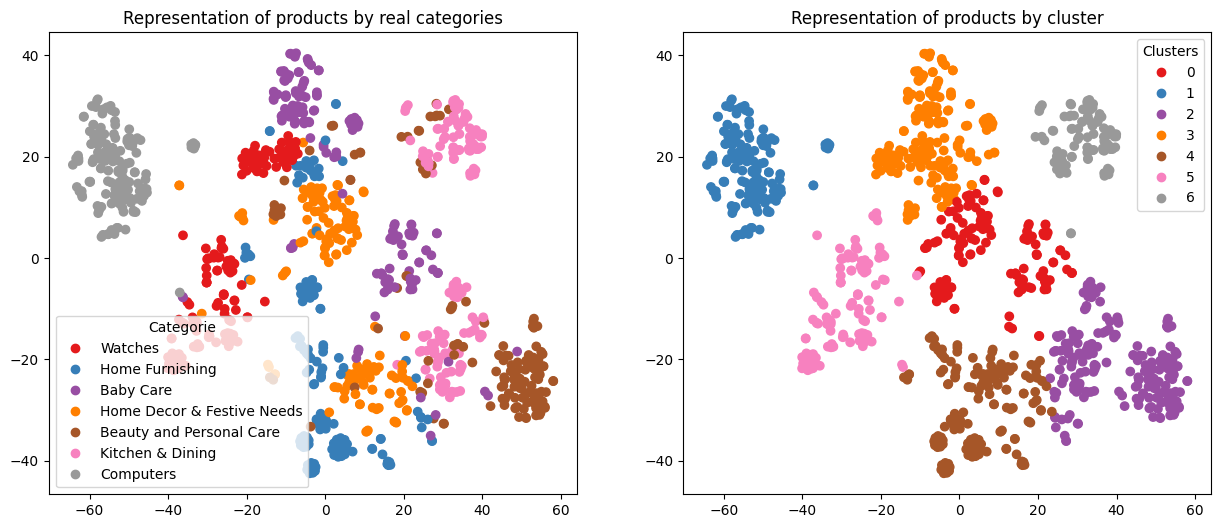

ARI :  0.4425


In [101]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [120]:
# final table ari_score
data_ari.sort_values('ARI_score',ascending= False)

Model  ARI_score  Time
1                                             TF_IDF     0.5530   7.0
2                                     TF_IDF_bigrams     0.5079   8.0
3                                    TF_IDF_trigrams     0.5057  11.0
7                                BERT_hub_Tensorflow     0.4688   8.0
8                         Universal Sentence Encoder     0.4425   8.0
0                                    CountVectorizer     0.4320  10.0
5                 BERT_HuggingFace_bert_base_uncased     0.3950   7.0
4                                           Word2Vec     0.3513   7.0
6  BERT_HuggingFace_cardiffnlp/twitter_roberta_ba...     0.1807   7.0

## FEATURES IMAGE

In [37]:
df.head(1)

uniq_id            crawl_timestamp                                        product_url                                       product_name                              product_category_tree               pid  retail_price  discounted_price                                 image  is_FK_Advantage_product                                        description       product_rating       overall_rating     brand                             product_specifications        cat_lvl_1               cat_lvl_2 cat_lvl_3                                          cat_lvl_4 cat_lvl_5 cat_lvl_6 cat_lvl_7                                       sentence_bow                                   sentence_bow_lem                                        sentence_dl  length_bow  length_dl
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000  http://www.flipkart.com/elegance-polyester-mul...  Elegance Polyester Multicolor Abstract Eyelet ...  [Home Furnishing, Curtains & Accessories, Curt...  CRNEG7BKMFFYHQ8Z        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False  Elegance Polyester Multicolor Abstract Eyelet ...  No rating available  No rating available  Elegance  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing  Curtains & Accessories  Curtains  Elegance Polyester Multicolor Abstract Eyelet ...                                elegance polyester multicolor abstract eyelet ...  elegance polyester multicolor abstract eyelet ...  elegance polyester multicolor abstract eyelet ...         162        254

In [38]:
from sklearn import preprocessing

list_labels = ['Watches', 'Home Furnishing', 'Baby Care', 'Home Decor & Festive Needs',
               'Beauty and Personal Care', 'Kitchen & Dining', 'Computers']
label_name = "no_name "

le = preprocessing.LabelEncoder()
df["label"] = le.fit_transform(df["cat_lvl_1"])
df.head()

uniq_id            crawl_timestamp                                        product_url                                       product_name                              product_category_tree               pid  retail_price  discounted_price                                 image  is_FK_Advantage_product                                        description       product_rating       overall_rating                  brand                             product_specifications        cat_lvl_1               cat_lvl_2         cat_lvl_3                                          cat_lvl_4                                          cat_lvl_5 cat_lvl_6 cat_lvl_7                                       sentence_bow                                   sentence_bow_lem                                        sentence_dl  length_bow  length_dl  label
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000  http://www.flipkart.com/elegance-polyester-mul...  Elegance Polyester Multicolor Abstract Eyelet ...  [Home Furnishing, Curtains & Accessories, Curt...  CRNEG7BKMFFYHQ8Z        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False  Elegance Polyester Multicolor Abstract Eyelet ...  No rating available  No rating available               Elegance  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing  Curtains & Accessories          Curtains  Elegance Polyester Multicolor Abstract Eyelet ...                                                                         elegance polyester multicolor abstract eyelet ...  elegance polyester multicolor abstract eyelet ...  elegance polyester multicolor abstract eyelet ...         162        254      4
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000  http://www.flipkart.com/sathiyas-cotton-bath-t...                         Sathiyas Cotton Bath Towel  [Baby Care, Baby Bath & Skin, Baby Bath Towels...  BTWEGFZHGBXPHZUH         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False  Sathiyas Cotton Bath TowelSpecifications of Sa...  No rating available  No rating available               Sathiyas  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care        Baby Bath & Skin  Baby Bath Towels                          Sathiyas Baby Bath Towels  Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...                      sathiyas cotton bath towelspecifications sathi...  sathiyas cotton bath towelspecifications sathi...  sathiyas cotton bath towelspecifications of sa...          66         87      0
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000  http://www.flipkart.com/eurospa-cotton-terry-f...                Eurospa Cotton Terry Face Towel Set  [Baby Care, Baby Bath & Skin, Baby Bath Towels...  BTWEG6SHXTDB2A2Y           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg                    False  Eurospa Cotton Terry Face Towel SetKey Feature...  No rating available  No rating available                Eurospa  {"product_specification"=>[{"key"=>"Material",...        Baby Care        Baby Bath & Skin  Baby Bath Towels                           Eurospa Baby Bath Towels  Eurospa Cotton Terry Face Towel Set (20 PIECE ...                      eurospa cotton terry face towel setkey feature...  eurospa cotton terry face towel setkey feature...  eurospa cotton terry face towel setkey feature...         163        257      0
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000  http://www.flipkart.com/santosh-royal-fashion-...  SANTOSH ROYAL FASHION Cotton Printed King size...  [Home Furnishing, Bed Linen, Bedsheets, SANTOS...  BDSEJT9UQWHDUBH4        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg                    False  SANTOSH ROYAL FASHION Cotton Printed King size...  No rating available  No rating available  SANTOSH ROYAL FASHION  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing               Bed Linen         Bedsheets                    SANTOSH ROYAL 

In [39]:
path = "C:/Users/pierr/Python/P6/Images/"

Watches
--------------------------------------------------------------


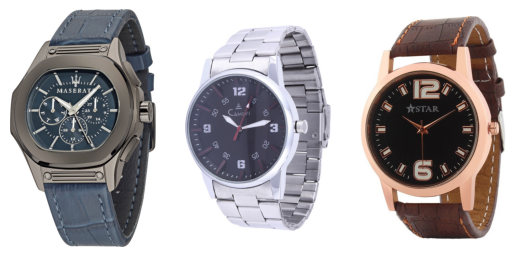

Home Furnishing
--------------------------------------------------------------


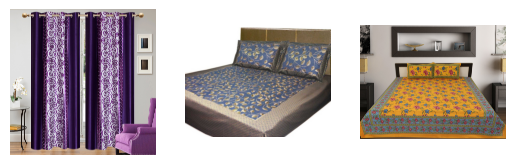

Baby Care
--------------------------------------------------------------


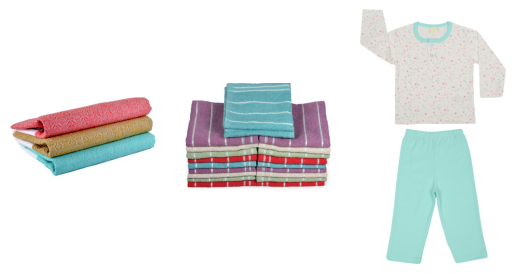

Home Decor & Festive Needs
--------------------------------------------------------------


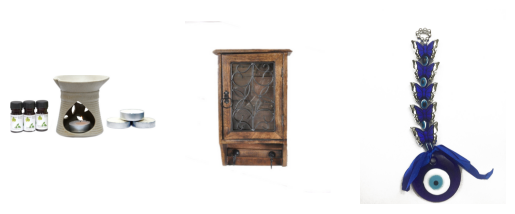

Beauty and Personal Care
--------------------------------------------------------------


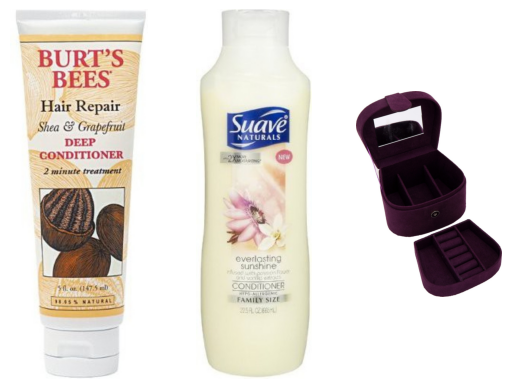

Kitchen & Dining
--------------------------------------------------------------


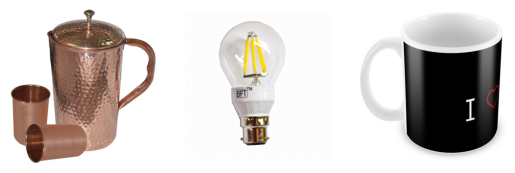

Computers
--------------------------------------------------------------


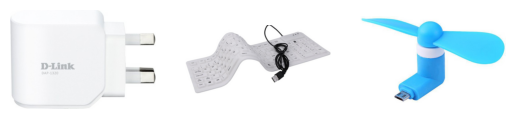

In [40]:
from matplotlib.image import imread

list_watches = [df[['image','cat_lvl_1']].iloc[i] for i in range(len(df)) if df["cat_lvl_1"][i]=='Watches']
list_home_furnishing = [df[['image','cat_lvl_1']].iloc[i] for i in range(len(df)) if df["cat_lvl_1"][i]=='Home Furnishing']
list_baby = [df[['image','cat_lvl_1']].iloc[i] for i in range(len(df)) if df["cat_lvl_1"][i]=='Baby Care']
list_decor = [df[['image','cat_lvl_1']].iloc[i] for i in range(len(df)) if df["cat_lvl_1"][i]=='Home Decor & Festive Needs']
list_beauty = [df[['image','cat_lvl_1']].iloc[i] for i in range(len(df)) if df["cat_lvl_1"][i]=='Beauty and Personal Care']
list_kitchen = [df[['image','cat_lvl_1']].iloc[i] for i in range(len(df)) if df["cat_lvl_1"][i]=='Kitchen & Dining']
list_computers = [df[['image','cat_lvl_1']].iloc[i] for i in range(len(df)) if df["cat_lvl_1"][i]=='Computers']

list_cat = [list_watches, list_home_furnishing, list_baby, list_decor,
            list_beauty, list_kitchen, list_computers]

for name in list_cat :
    print(name[0][1]) 
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + name[i][0]
        image = imread(filename)
        plt.axis('off')
        plt.imshow(image)
    print('-------------------------------'*2)
    plt.show()

## Détermination et affichage des descripteurs ORB


In [42]:
import cv2

orb = cv2.ORB_create()
image = cv2.imread(path+df['image'][0],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
image = cv2.resize(image, (750, 500))
kp, des = orb.detectAndCompute(image, None)
img = cv2.drawKeypoints(image,kp,image)
#plt.imshow(img)
#plt.show()
cv2.imshow("Image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()
print("Descripteurs : ", des.shape)
print()
print(des)

Descripteurs :  (500, 32)

[[142 158 194 ... 125 124 155]
 [ 99 104   9 ... 203  24 152]
 [ 47  38 224 ... 253 218 132]
 ...
 [159 253 190 ... 255 188  87]
 [111 186 174 ... 172 126 247]
 [230 237 245 ... 255 208  15]]


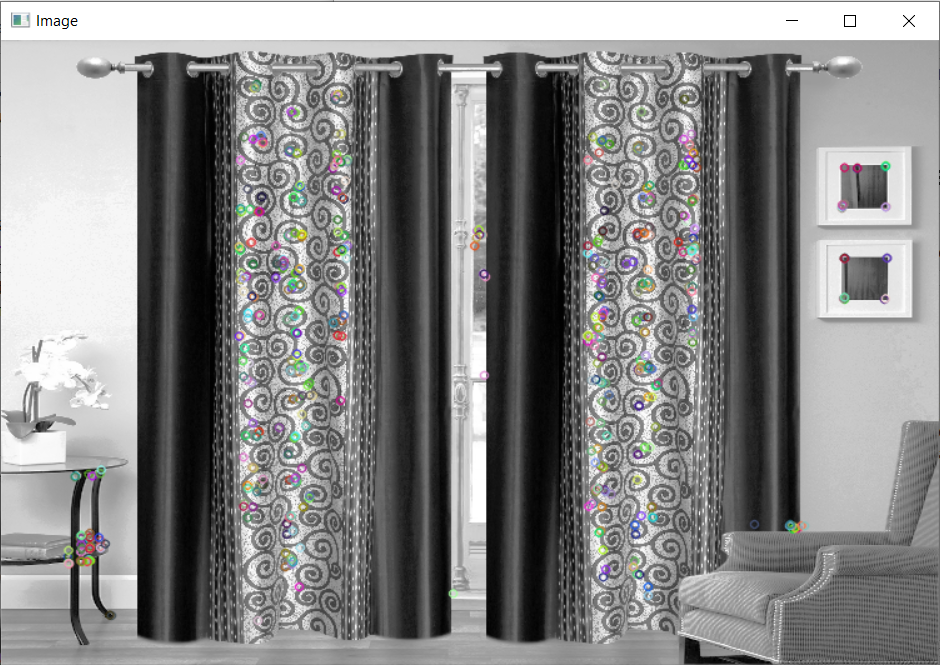

In [42]:
Image(filename='D:/pierr/Documents/images/rideau_descriptions.png',width=750,height=500)

## Créations des descripteurs de chaque image

In [43]:
# identification of key points and associated descriptors
import time, cv2
orb_keypoints = []
temps1 = time.time()
orb = cv2.ORB_create(1050)

for image_num in range(len(df['image'])) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path + df['image'][image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = orb.detectAndCompute(res, None)
    orb_keypoints.append(des)

orb_keypoints_by_img = np.asarray(orb_keypoints)
orb_keypoints_all    = np.concatenate(orb_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", orb_keypoints_all.shape)

duration1 = time.time() - temps1
print("temps de traitement ORB descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (1083667, 32)
temps de traitement ORB descriptor :            43.06 secondes


## Création des clusters de descripteurs

In [44]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1 = time.time()

k = int(round(np.sqrt(len(orb_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(orb_keypoints_all)

duration1 = time.time() - temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  1041
Création de 1041 clusters de descripteurs ...
temps de traitement kmeans :            12.12 secondes


## Création des features des images

In [45]:
# Creation of histograms (features)
temps1 = time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(orb_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time() - temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             5.24 secondes


## Réductions de dimension

In [46]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 1041)
Dimensions dataset après réduction PCA :  (1050, 709)


## Réduction de dimension T-SNE

In [47]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df['cat_lvl_1']
print(df_tsne.shape)

(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images

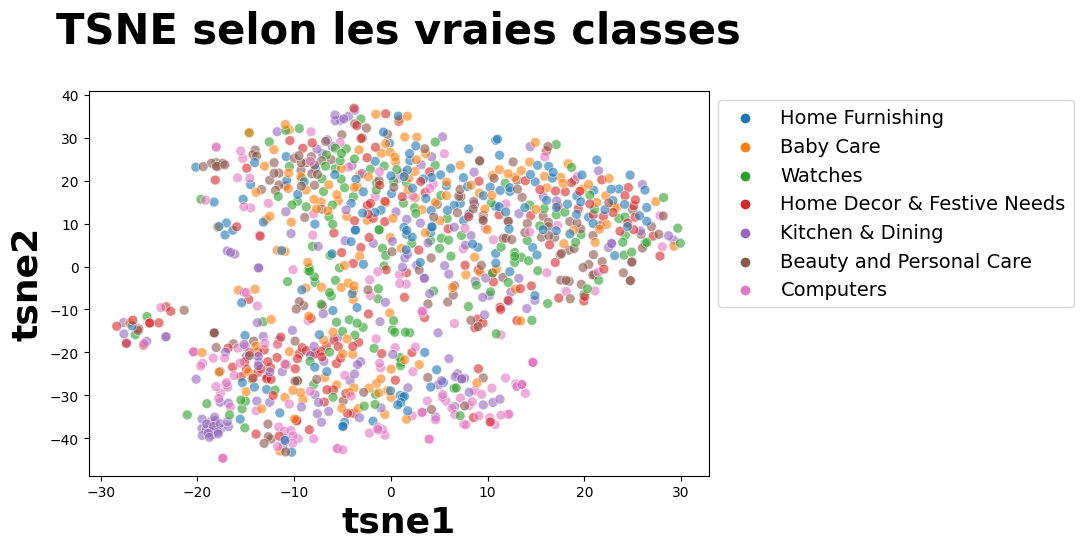

In [48]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend ="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14},bbox_to_anchor=(1, 1, 0., 0.)) 

plt.show()

## Analyse mesures : similarité entre catégories et clusters

### Création de clusters à partir du T-SNE

In [49]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


### Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

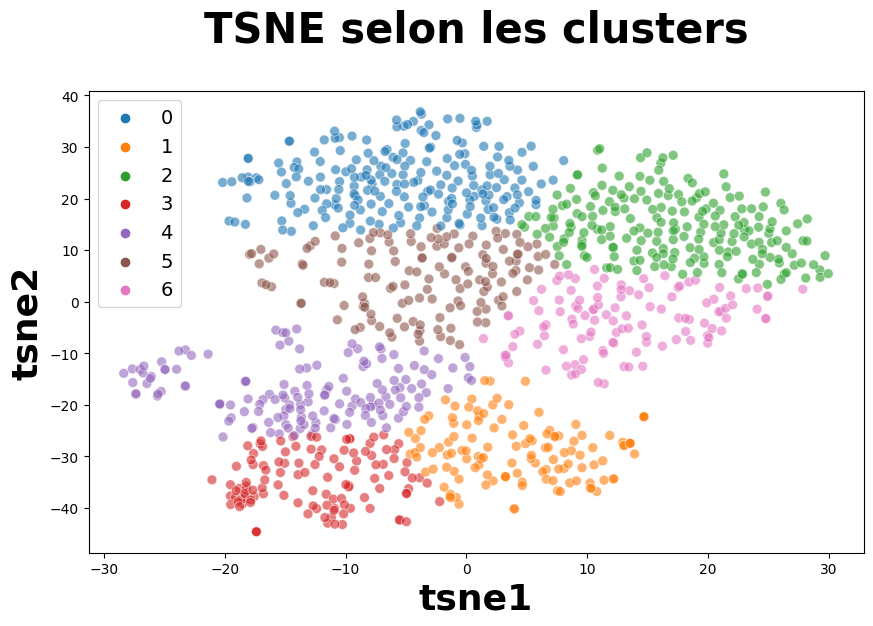

ARI :  0.03723977221121355


In [50]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes

In [51]:
df_tsne.head()

tsne1      tsne2            class  cluster
0  20.452545  11.457410  Home Furnishing        2
1  15.887753  20.985287        Baby Care        2
2 -10.296772  10.332630        Baby Care        5
3  23.592829  18.009623  Home Furnishing        2
4   8.041106  27.349089  Home Furnishing        0

In [52]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    206
1    126
2    205
3    114
4    147
5    138
6    114
Name: class, dtype: int64

In [53]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[40 15 34 11 17 26  7]
 [41  5 44 10 15  7 28]
 [21 53  9 25 21 10 11]
 [19  7 27 13 46 16 22]
 [33 12 51 10  8 27  9]
 [16 22 15 34 25 22 16]
 [36 12 25 11 15 30 21]]


In [54]:
corresp = np.argmax(conf_mat, axis=0)
corresp

array([1, 2, 4, 5, 3, 6, 1], dtype=int64)

In [55]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [0,6,1,4,2,3,5]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [0, 6, 1, 4, 2, 3, 5]
[[40 34 17 26 11  7 15]
 [41 44 15  7 10 28  5]
 [21  9 21 10 25 11 53]
 [19 27 46 16 13 22  7]
 [33 51  8 27 10  9 12]
 [16 15 25 22 34 16 22]
 [36 25 15 30 11 21 12]]

              precision    recall  f1-score   support

           0       0.19      0.27      0.22       150
           1       0.21      0.29      0.25       150
           2       0.14      0.14      0.14       150
           3       0.12      0.11      0.11       150
           4       0.09      0.07      0.08       150
           5       0.14      0.11      0.12       150
           6       0.10      0.08      0.09       150

    accuracy                           0.15      1050
   macro avg       0.14      0.15      0.14      1050
weighted avg       0.14      0.15      0.14      1050



<Axes: >

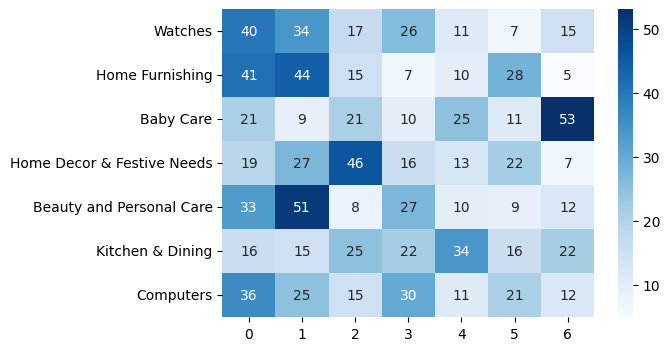

In [56]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## CNN Transfert Learning 

In [41]:
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model
from pickle import dump

# load an image from file
image = load_img('C:/Users/pierr/Python/P6/Images/1e15dbd9f59a8b2001f91d18ddc84b5a.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# load the model
model = VGG16()
# predict the probability across all output classes
yhat = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

1/1 [==============================] - 1s 836ms/step
stopwatch (48.78%)


In [74]:
def VGG16_extracteur(nom_image):
    # load an image from file
    image = load_img('C:/Users/pierr/Python/P6/Images/'+ nom_image, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # load model
    model = VGG16()
    # remove the output layer
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # get extracted features
    im_features = model.predict(image)
    
    return im_features

In [75]:
VGG16_extracteur('1e15dbd9f59a8b2001f91d18ddc84b5a.jpg')

1/1 [==============================] - 0s 316ms/step


array([[0.      , 0.      , 0.      , ..., 4.521576, 0.      , 0.      ]],
      dtype=float32)

In [76]:
images_list_vgg16 = []

for image in df["image"]:
    
    images_list_vgg16.append(VGG16_extracteur(image))
    

1/1 [==============================] - 1s 717ms/step


MemoryError: Unable to allocate 392. MiB for an array with shape (25088, 4096) and data type float32

In [68]:
arr_features = np.asarray(images_list)
arr_features = np.concatenate(arr_features, axis=0)
arr_features.shape

(36, 4096)

In [80]:
df.head(1)

uniq_id            crawl_timestamp                                        product_url                                       product_name                              product_category_tree               pid  retail_price  discounted_price                                 image  is_FK_Advantage_product                                        description       product_rating       overall_rating     brand                             product_specifications        cat_lvl_1               cat_lvl_2 cat_lvl_3                                          cat_lvl_4 cat_lvl_5 cat_lvl_6 cat_lvl_7                                       sentence_bow                                   sentence_bow_lem                                        sentence_dl  length_bow  length_dl  label
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000  http://www.flipkart.com/elegance-polyester-mul...  Elegance Polyester Multicolor Abstract Eyelet ...  [Home Furnishing, Curtains & Accessories, Curt...  CRNEG7BKMFFYHQ8Z        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False  Elegance Polyester Multicolor Abstract Eyelet ...  No rating available  No rating available  Elegance  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing  Curtains & Accessories  Curtains  Elegance Polyester Multicolor Abstract Eyelet ...                                elegance polyester multicolor abstract eyelet ...  elegance polyester multicolor abstract eyelet ...  elegance polyester multicolor abstract eyelet ...         162        254      4

In [81]:
vgg16_feature_list = []

for img_path in df["image"]:
    
    img = load_img('C:/Users/pierr/Python/P6/Images/'+ img_path, target_size=(224, 224))
    img_data = img_to_array(img)
    # Redimensionnement
    img_data = np.expand_dims(img_data, axis=0)
    # Préparer de nouvelles entrées pour le réseau.
    img_data = preprocess_input(img_data)

    vgg16_feature = model.predict(img_data)
    vgg16_feature_np = np.array(vgg16_feature)
    vgg16_feature_list.append(vgg16_feature_np.flatten())
        
vgg16_feature_list_np = np.array(vgg16_feature_list)

1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 187ms/step


1/1 [==============================] - 0s 225ms/step


1/1 [==============================] - 0s 284ms/step


In [141]:
vgg16_feature_list_np.shape

(1050, 1000)

## Réductions de dimension

In [134]:
print("Dimensions dataset avant réduction PCA : ", vgg16_feature_list_np.shape)
pca = decomposition.PCA(n_components=0.99)
   
feat_pca = pca.fit_transform(vgg16_feature_list_np)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 1000)
Dimensions dataset après réduction PCA :  (1050, 202)


## Réductions de dimension T-SNE

In [130]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(vgg16_feature_list_np)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df['cat_lvl_1']
print(df_tsne.shape)

(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images

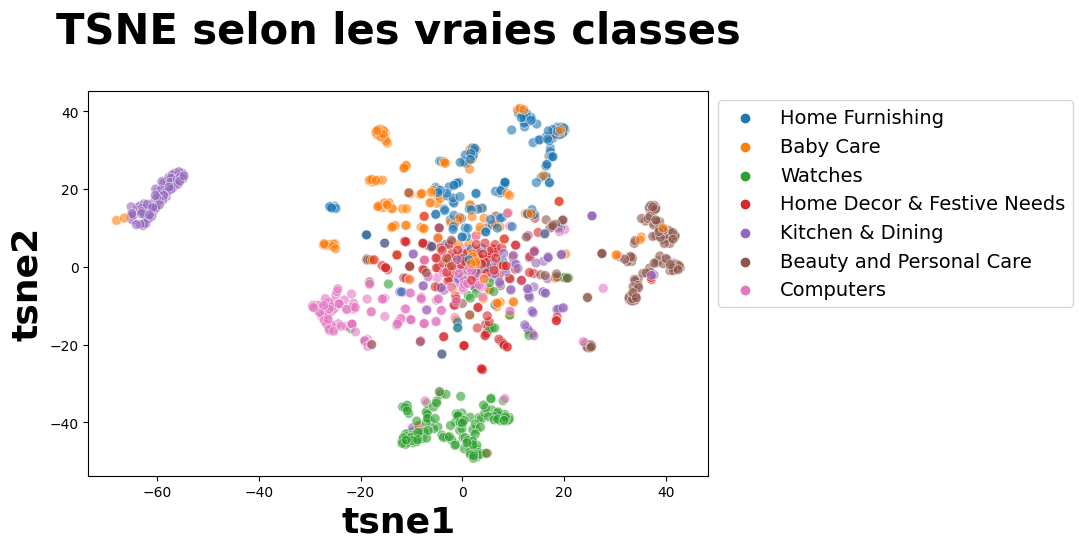

In [131]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend ="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14},bbox_to_anchor=(1, 1, 0., 0.)) 

plt.show()

## Analyse mesures : similarité entre catégories et clusters

### Création de clusters à partir du T-SNE

In [132]:
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


### Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

Score ARI 0.37

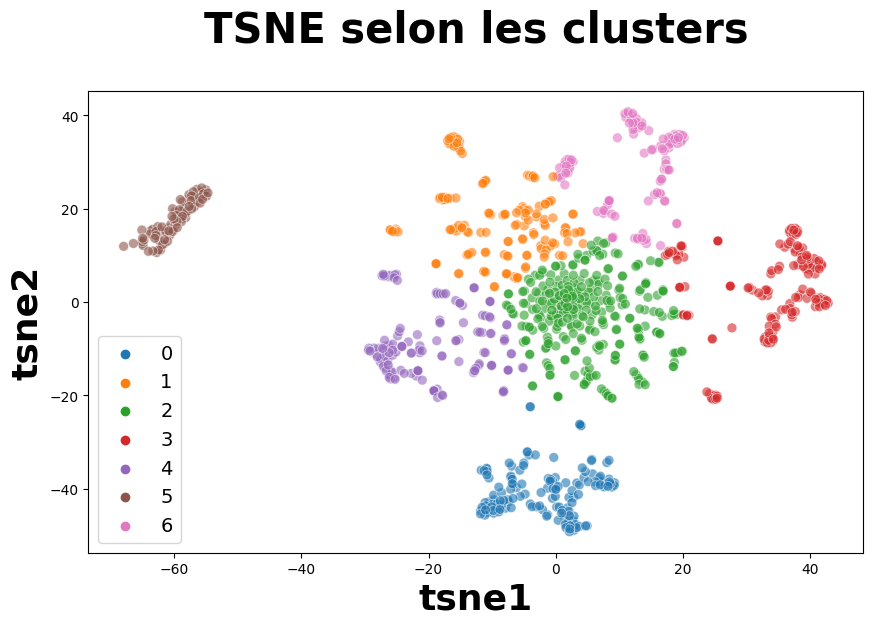

ARI :  0.37236081685722855


In [133]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes

In [91]:
df_tsne.head()

tsne1      tsne2            class  cluster
0  16.600201  26.322392  Home Furnishing        6
1   1.760294  30.536573        Baby Care        6
2   1.727700  28.158886        Baby Care        6
3  20.181768  35.186104  Home Furnishing        6
4  11.449153  39.583565  Home Furnishing        6

In [92]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    144
1    147
2    292
3    146
4    139
5     77
6    105
Name: class, dtype: int64

In [93]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[  0  80  29   6  13   2  20]
 [  2   1  17 116  10   0   4]
 [  3   0  40   5 100   0   2]
 [  7  15 112   2   9   0   5]
 [  1  49  22   3   1   0  74]
 [  1   2  58  10   4  75   0]
 [130   0  14   4   2   0   0]]


In [96]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [1,3,4,2,6,5,0]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [1, 3, 4, 2, 6, 5, 0]
[[ 20   0   6  80  29   2  13]
 [  4   2 116   1  17   0  10]
 [  2   3   5   0  40   0 100]
 [  5   7   2  15 112   0   9]
 [ 74   1   3  49  22   0   1]
 [  0   1  10   2  58  75   4]
 [  0 130   4   0  14   0   2]]

              precision    recall  f1-score   support

           0       0.19      0.13      0.16       150
           1       0.01      0.01      0.01       150
           2       0.03      0.03      0.03       150
           3       0.10      0.10      0.10       150
           4       0.08      0.15      0.10       150
           5       0.97      0.50      0.66       150
           6       0.01      0.01      0.01       150

    accuracy                           0.13      1050
   macro avg       0.20      0.13      0.15      1050
weighted avg       0.20      0.13      0.15      1050



<Axes: >

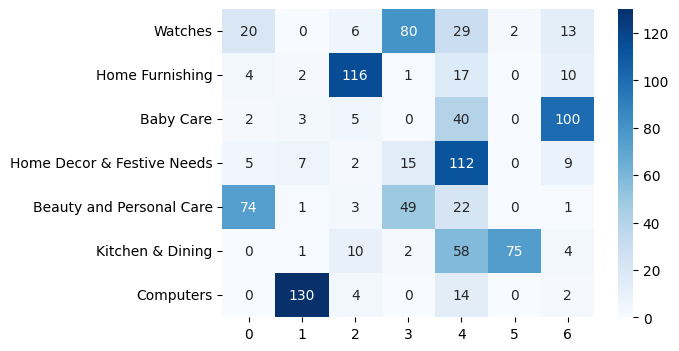

In [97]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d')

## Xception 

In [42]:
from tensorflow import keras

model_2 = keras.applications.Xception()

In [66]:
def Xception_extracteur(nom_image):
    # load an image from file
    image = load_img('C:/Users/pierr/Python/P6/Images/'+ nom_image, target_size=(299, 299))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # load model
    model = keras.applications.Xception()
    # remove the output layer
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # get extracted features
    im_features = model.predict(image)
    
    return im_features

In [67]:
Xception_extracteur('1e15dbd9f59a8b2001f91d18ddc84b5a.jpg')

1/1 [==============================] - 1s 955ms/step


array([[ 0.      ,  8.810809, 10.73906 , ...,  0.      ,  4.877595,
         0.      ]], dtype=float32)

In [68]:
images_list = []

for image in df["image"]:
    
    images_list.append(Xception_extracteur(image))

1/1 [==============================] - 1s 802ms/step


1/1 [==============================] - 1s 787ms/step


1/1 [==============================] - 1s 818ms/step


1/1 [==============================] - 1s 800ms/step


In [70]:
import pickle
# Sauvegarde des descripteurs calculés (pickle)
pickle.dump(images_list, open('images_list_Xception.pkl', 'wb'))

In [44]:
import pickle
# Chargement des descripteurs calculés (pickle)
list_features = pickle.load(open('images_list_Xception.pkl', 'rb'))

In [46]:
arr_features = np.asarray(list_features)
arr_features = np.concatenate(arr_features, axis=0)
arr_features.shape

(1050, 2048)

## Réduction de dimension 

In [48]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", arr_features.shape)
pca = decomposition.PCA(n_components=0.99)
   
feat_pca = pca.fit_transform(arr_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 2048)
Dimensions dataset après réduction PCA :  (1050, 95)


## Réductions de dimension T-SNE 

In [58]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df['cat_lvl_1']
print(df_tsne.shape)

(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images

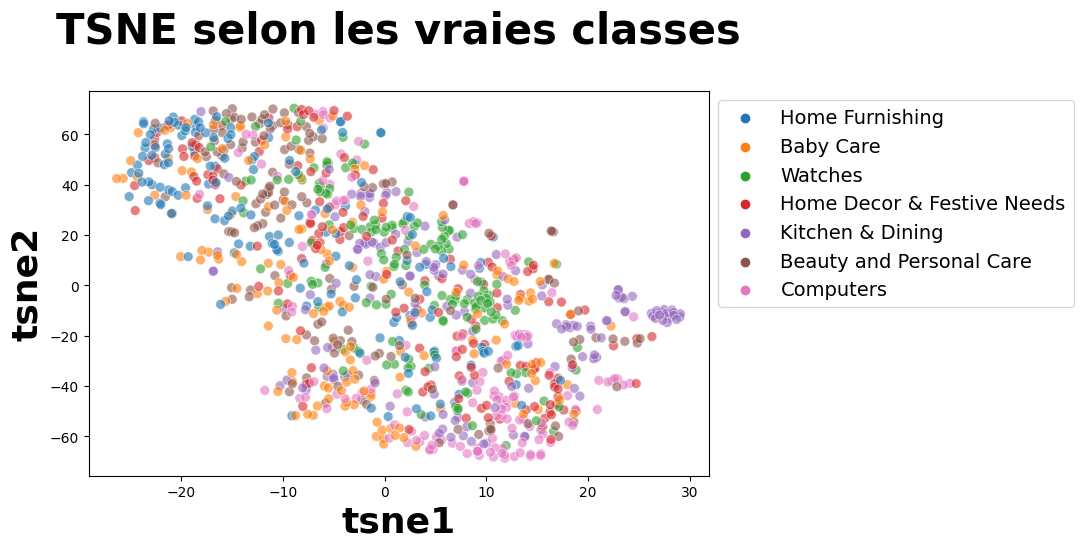

In [59]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend ="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14},bbox_to_anchor=(1, 1, 0., 0.)) 

plt.show()

## Analyse mesures : similarité entre catégories et clusters

### Création de clusters à partir du T-SNE

In [60]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


### Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

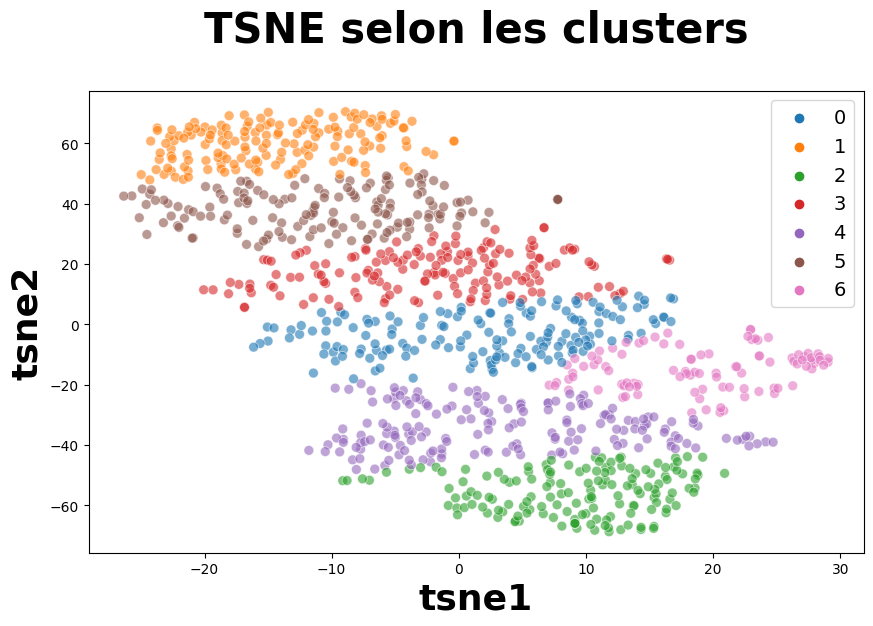

ARI :  0.04780960914158789


In [61]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

## RESNET 

In [62]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [63]:
model_3 = ResNet50()

102967424/102967424 [==============================] - 44s 0us/step


In [66]:
def Resnet_extracteur(nom_image):
    # load an image from file
    image = load_img('C:/Users/pierr/Python/P6/Images/'+ nom_image, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # load model
    model = ResNet50()
    # remove the output layer
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # get extracted features
    im_features = model.predict(image)
    
    return im_features

In [67]:
Resnet_extracteur('1e15dbd9f59a8b2001f91d18ddc84b5a.jpg')

1/1 [==============================] - 1s 1s/step


array([[0.07290827, 0.24352849, 0.4047012 , ..., 0.03605971, 0.15924716,
        0.9648724 ]], dtype=float32)

In [68]:
images_list_2 = []

for image in df["image"]:
    
    images_list_2.append(Resnet_extracteur(image))

1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 1s 1s/step


In [69]:
# Sauvegarde des descripteurs calculés (pickle)
pickle.dump(images_list_2, open('images_list_Resnet.pkl', 'wb'))

In [70]:
# Chargement des descripteurs calculés (pickle)
list_features_2 = pickle.load(open('images_list_Resnet.pkl', 'rb'))

In [71]:
arr_features_2 = np.asarray(list_features_2)
arr_features_2 = np.concatenate(arr_features_2, axis=0)
arr_features_2.shape

(1050, 2048)

## Réduction de dimension

In [ ]:
Fais perdre ENORMEMENT DE SCORE

## Réduction de dimension T_NSE

In [85]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(arr_features_2)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df['cat_lvl_1']
print(df_tsne.shape)

(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images

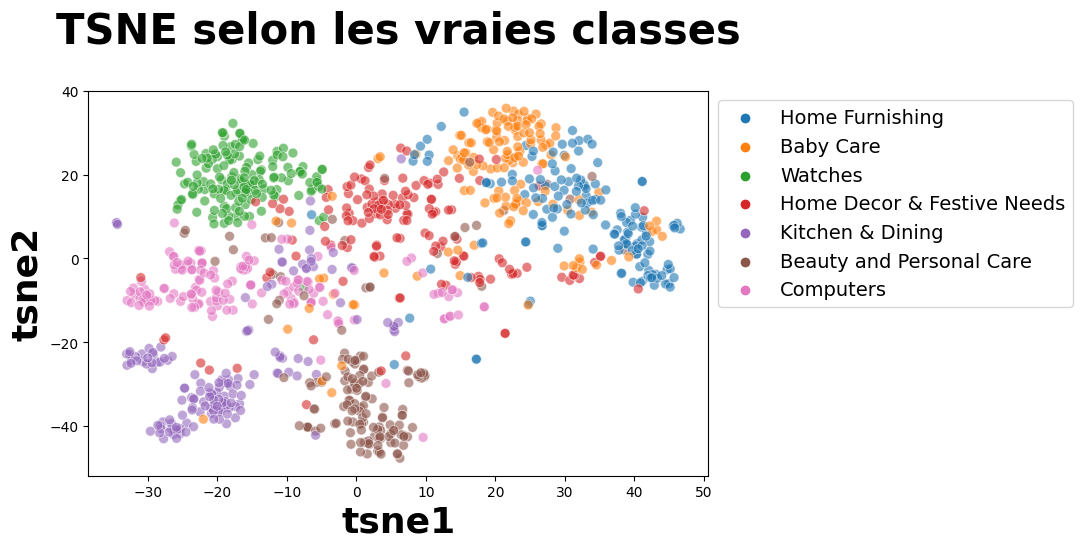

In [86]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend ="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14},bbox_to_anchor=(1, 1, 0., 0.)) 

plt.show()

## Analyse mesures : similarité entre catégories et clusters

### Création de clusters à partir du T-SNE

In [87]:
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


### Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

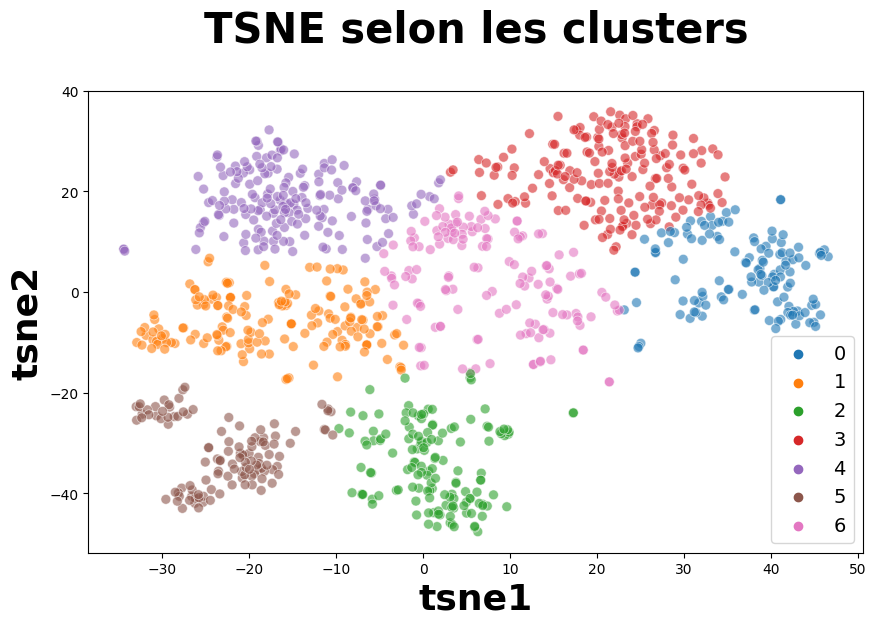

ARI :  0.5423677369673608


In [88]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

## Analyse par classes

In [76]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    125
1    166
2    140
3    181
4    177
5    116
6    145
Name: class, dtype: int64

In [77]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[ 20   5   3 110   3   1   8]
 [  2  13 118   4   1   1  11]
 [  0 124   3   1   2   0  20]
 [ 12   5   4  15  16   5  93]
 [ 91   0   3  50   1   0   5]
 [  0  18   9   1   5 109   8]
 [  0   1   0   0 149   0   0]]


In [78]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [3,2,1,6,0,5,4]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [3, 2, 1, 6, 0, 5, 4]
[[  3   3   5  20   8   1 110]
 [  1 118  13   2  11   1   4]
 [  2   3 124   0  20   0   1]
 [ 16   4   5  12  93   5  15]
 [  1   3   0  91   5   0  50]
 [  5   9  18   0   8 109   1]
 [149   0   1   0   0   0   0]]

              precision    recall  f1-score   support

           0       0.02      0.02      0.02       150
           1       0.84      0.79      0.81       150
           2       0.75      0.83      0.78       150
           3       0.10      0.08      0.09       150
           4       0.03      0.03      0.03       150
           5       0.94      0.73      0.82       150
           6       0.00      0.00      0.00       150

    accuracy                           0.35      1050
   macro avg       0.38      0.35      0.37      1050
weighted avg       0.38      0.35      0.37      1050



<Axes: >

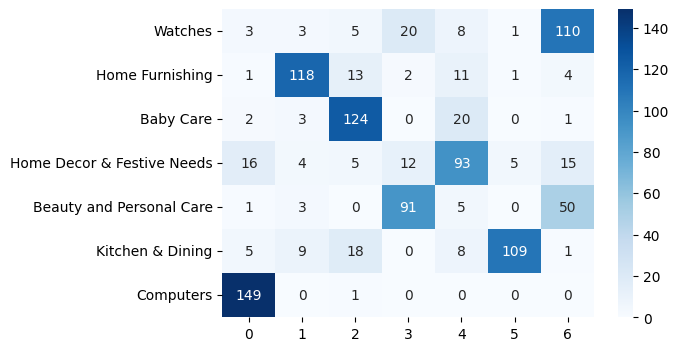

In [79]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d')

# Conclusion 